# Working out how to filter and interpolate data
This is just an exploritory file, the actual functions were sped up a little and fully implented into a tool in the tools/convertCANData.py file.

We need a way to interopolate the car parameters at each image.

The way I am going to apporach this is:
1. For each car parameter, remove any data that does not have a data point within maxDelta
2. Get a list of times there are images for
3. for each car parameter, remove any images that there is not data within maxDelta time
4. Create an interpolation function for each car parameter
5. For each remaining image, interpolate the car parameter at the image time.
6. Save a csv with image names and car parameters for each image


## approach to filtering the data by image times
* get np array of image time stamps
* get np array of datapoint time stamps
* do a mesh grid of the 2 arrays
* * need to track which one is the image and which is data point meshes
* subtract the arrays
* np.where np.abs(value) > max delta # abs is needed so it can be +/-
* * note which index is which
* in the output that is for the data points, remove all data points that are not listed from the data frame
* in the output indicies for the images, remove any image indicies from the image time list that do not show up in the np.where output.


This should only need to be run over the data once. I think this because: in each dataframe an image may be removed, but we will only be interpolating the dataframe to the images that remain at the end. This means that there may be data left in the data frame for say steering, even though there is no speed data near this time. When the image time filtering is run on the speed data, it will remove the image at times where speed is missing. When the final interpolation happens, it will be based purely on the remaining images. 

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def filterDataByDelta(data,maxDelta=1.0):
    '''
    Takes in a data frame with the columns: TimeStamp and output
    Returns a dataframe with columns: TimeStamp and output that has 1 less row the the source dataframe
    
    Filters the data frame so that any output row that does not have an output in the 
        next maxDeta seconds is removed
    '''
    ts = pd.DataFrame(data.TimeStamp[:-1]) # get first time stamp, drop last point
    ts2 = pd.DataFrame(data.TimeStamp[1:]) # get the next time stamp, drop first point
    data = data[:-1] # remove last data point
    ts2 = ts2.reset_index(drop=True) # reset the index 
    delta = ts2-ts# compute delta
    data = data.assign(delta=delta) # put the delta column into data frame
    data = data[data.delta<maxDelta] # filter out deltas that are too big
    data = data.reset_index() # need to reset at the end
    data = data.drop(labels="delta",axis=1) # get rid of delta column

    return data

In [3]:
def GetData(path,dataType,maxDelta=1.0):
    if not dataType.endswith(".csv"):
        dataType = dataType + ".csv"
    fileName = os.path.join(path,dataType)
    assert os.path.isfile(fileName), "File does not exist: {}".format(fileName)
    
    data = pd.read_csv(fileName)
    data = filterDataByDelta(data)
    data = data.sort_values("TimeStamp")
    return data    

In [4]:
def GetImageTimes(path,extension="jpeg"):
    '''
    Given a path and extension(default=jpeg), get all the files in the path that match the extension
    Return a list of times
    
    This assumes that file names are decimal times in seconds
    '''
    assert os.path.exists(path), "Provided path does not exist!\n{}".format(path)
    imgs = [x for x in os.listdir(path) if extension in x]
    assert len(imgs) > 2, "There must be at least 2 images of type {} in the path {}".format(extension,path)    
    
    extensionLength = len(extension)+1
    times = [float(t[:-extensionLength]) for t in imgs]
    times = np.array(times)
    times = np.sort(times)

    return times

In [5]:
def filterImgTimesByDataTimes(imgTimes,dataTimes,maxDelta=1.0):
    '''
    Given np arrays of image times and data times, 
        filter the image times so that there is always a data point within maxDelta of the image
    1) get 1D array of times of images, imgTimes
    2) get 1D array of times of samples, dataTimes
    3) IMGTimes,DATATimes = np.meshgrid(imgTimes,dataTimes)
    4) locs = np.where(np.abs(IMGTimes-DATATimes)<=maxDelta)
    * The result in locs is (idx of dataTimes, idx of imgTimes)
    5) imgLocs = np.unique(locs[1])
    6) imgTimes = imgTimes[imgLocs]
    '''
    dataTimes = np.sort(dataTimes)
    IMGTimes,DATATimes = np.meshgrid(imgTimes,dataTimes)
    locs = np.where(np.abs(IMGTimes-DATATimes)<maxDelta)
    imgLocs = np.unique(locs[1])
    return imgTimes[imgLocs]

Starting with 12888 image times
Now have 12782 image times after filtering with steeringWheelAngle
Now have 12715 image times after filtering with steeringWheelTorque
Now have 12710 image times after filtering with turnSignal
Now have 12690 image times after filtering with vehicleSpeed


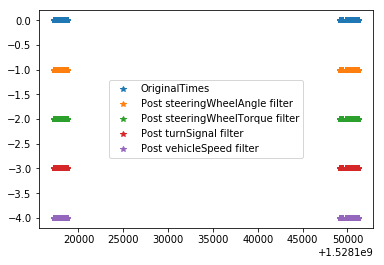

In [29]:
path = "/home/neil/car/DrivingData/20180604"
dataToExtract = ["steeringWheelAngle","steeringWheelTorque","turnSignal","vehicleSpeed"]#,"throttlePosition"]
maxDelta = 1
imgTimes = GetImageTimes(os.path.join(path,"imgs"))
print("Starting with {} image times".format(len(imgTimes)))
plt.plot(imgTimes,np.zeros(imgTimes.shape[0]),'*',label="OriginalTimes")

data = {}
for idx,d in enumerate(dataToExtract):
    data.update({d:GetData(path,d,maxDelta=maxDelta)})
    dataTimes = np.array(data[d].TimeStamp)
    imgTimes = filterImgTimesByDataTimes(imgTimes,dataTimes,maxDelta=maxDelta)
    print("Now have {} image times after filtering with {}".format(len(imgTimes),d))
    plt.plot(imgTimes,np.zeros(imgTimes.shape[0])-idx-1,'*',label="Post {} filter".format(d))
plt.legend()
plt.show()

# now get the values at each imgTime
interpolatedData = pd.DataFrame(imgTimes,columns=["TimeStamp"])
interpolatedData = interpolatedData.sort_values("TimeStamp")
for idx,d in enumerate(dataToExtract):
    rawX = np.array(data[d].TimeStamp)
    rawY = np.array(data[d].output)
    interpolatedData[d] = np.interp(imgTimes,rawX,rawY)
    
interpolatedData.to_csv(os.path.join(path,"interpolatedData.csv"),index=False)